## CSH Commands used in the making of this report

### Installing dependencies

sudo apt-get install build-essential libboost-all-dev cmake zlib1g-dev libbz2-dev liblzma-dev

### Installing Kenlm 

wget -O - https://kheafield.com/code/kenlm.tar.gz |tar xz
mkdir kenlm/build
cd kenlm/build
cmake ..
make -j2

### Training the model

 find /home/joebr/kenlm/data/ -type f -exec cat {} + | bin/lmplz -o 2 > model.arpa

# 0. Imports

In [1]:
import kenlm
import re
import glob
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
 
#PATH = r"C:\Users\barka\Desktop\NLP\Data\"
PATH = r"C:\Users\Louis\Documents\University\Masters\A23\NLP\Devoirs\data\hw1\train"
#PATH = r"C:\Users\barka\Desktop\NLP\Data\test.txt"

# a. Model Stats

### Load model

In [35]:
model_kenlm = kenlm.LanguageModel(r"C:\Users\Louis\Documents\University\Masters\A23\NLP\model2G.arpa")

### Load Test_set

In [117]:
f = open(PATH, "r", encoding="utf-8")
sentences = f.readlines()[:1000]

### Calculate perplexity

In [ ]:
perplexities = []
for sentence in sentences:
    sentence_filtered = sentence.replace('\n', '')
    score = model_kenlm.perplexity(sentence_filtered)
    perplexities.append(score)

### Statistics

In [24]:
perp_df = pd.Series(perplexities)

perp_df.describe()

count     1000.000000
mean       412.933038
std       1026.208320
min         28.735342
25%        145.652765
50%        227.562864
75%        419.894973
max      21411.129543
dtype: float64

# b. Slices Performance

In [120]:
perplexities_by_model = []
for i in range(1,10):

    model_i = kenlm.LanguageModel(fr"C:\Users\barka\Desktop\NLP\Model\Bimodel_{i}.arpa")

    perplexities = []
    for sentence in sentences:
        sentence_filtered = sentence.replace('\n', '')
        score = model_i.perplexity(sentence_filtered)
        perplexities.append(score)
    
    perplexities_by_model.append(perplexities)

In [121]:
perplexities_by_model = np.array(perplexities_by_model)
avg_perplexities_by_model = np.mean(perplexities_by_model, axis = 1)
avg_perplexities_by_model

array([519.21470454, 459.76954291, 452.83803246, 445.56337716,
       433.42662473, 432.01969488, 418.98937729, 416.18992388,
       412.93303849])

In [146]:
Temps_CPU = np.array([10.4654, 19.9174, 24.4909, 29.6741, 39.1275, 41.5106, 47.1417, 51.1339, 56.4883])
Memoire = np.array([53543, 87435, 115548, 140910, 164432, 186094, 206837, 226067, 244980])
Nu_of_slices = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
column_values = ['Number of slices trained on', 'Average perplexity', 'CPU Time (s)', 'Disk space (kB)']
index_values = ['Bimodel 1', 'Bimodel 2', 'Bimodel 3', 'Bimodel 4', 'Bimodel 5', 'Bimodel 6', 'Bimodel 7', 'Bimodel 8', 'Bimodel 9']

In [147]:
data = {'Number of slices trained on': Nu_of_slices,
        'Average perplexity': avg_perplexities_by_model,
        'CPU Time (s)': Temps_CPU,
        'Disk space (kB)' : Memoire}

df = pd.DataFrame(data, columns=column_values, index=index_values)
df

Number of slices trained on  Average perplexity  CPU Time (s)  \
Bimodel 1                            1          519.214705       10.4654   
Bimodel 2                            2          459.769543       19.9174   
Bimodel 3                            3          452.838032       24.4909   
Bimodel 4                            4          445.563377       29.6741   
Bimodel 5                            5          433.426625       39.1275   
Bimodel 6                            6          432.019695       41.5106   
Bimodel 7                            7          418.989377       47.1417   
Bimodel 8                            8          416.189924       51.1339   
Bimodel 9                            9          412.933038       56.4883   

           Disk space (kB)  
Bimodel 1            53543  
Bimodel 2            87435  
Bimodel 3           115548  
Bimodel 4           140910  
Bimodel 5           164432  
Bimodel 6           186094  
Bimodel 7           206837  
Bimodel 8           226067  
Bimodel 9           244980

## Figures

###  Perplexity vs. Number of Slices Trained On

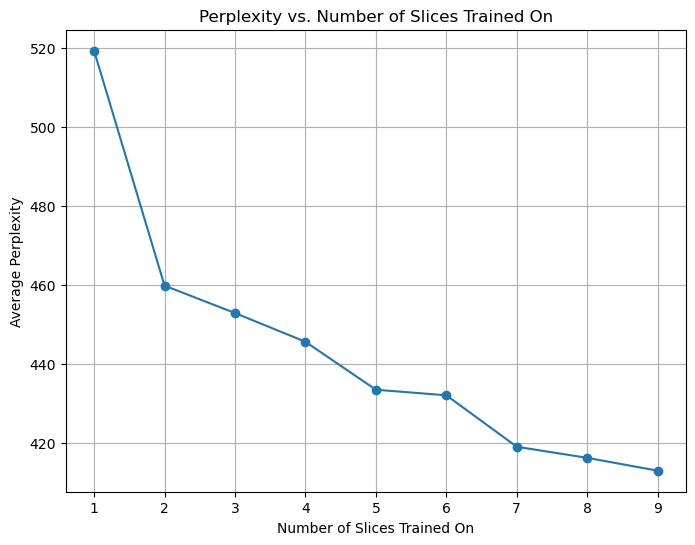

In [148]:
#perx per number slice
plt.figure(figsize=(8, 6))
plt.plot(df['Number of slices trained on'], df['Average perplexity'], marker='o', linestyle='-')
plt.title('Perplexity vs. Number of Slices Trained On')
plt.xlabel('Number of Slices Trained On')
plt.ylabel('Average Perplexity')
plt.grid(True)
plt.show()

### Number of Slices vs. Disk Space

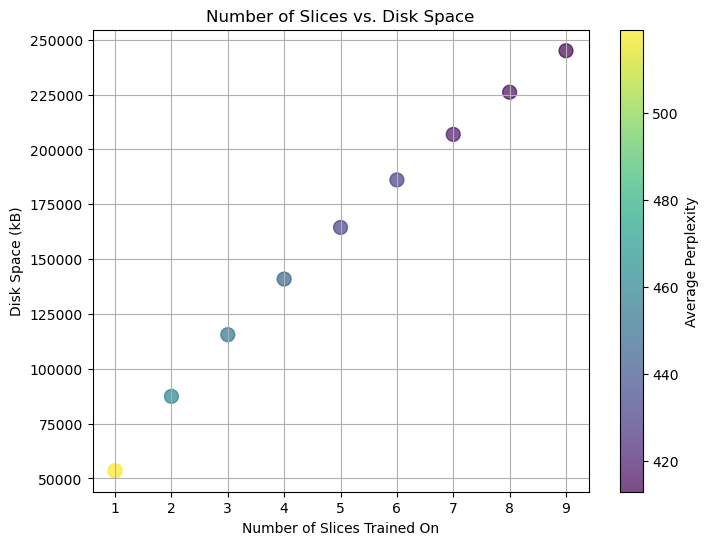

In [149]:
#number slice avec storage space

plt.figure(figsize=(8, 6))
plt.scatter(df['Number of slices trained on'], df['Disk space (kB)'], c=df['Average perplexity'], cmap='viridis', s=100, alpha=0.7)
plt.title('Number of Slices vs. Disk Space')
plt.xlabel('Number of Slices Trained On')
plt.ylabel('Disk Space (kB)')
plt.colorbar(label='Average Perplexity')
plt.grid(True)
plt.show()

### Number of Slices vs. CPU Time (s)

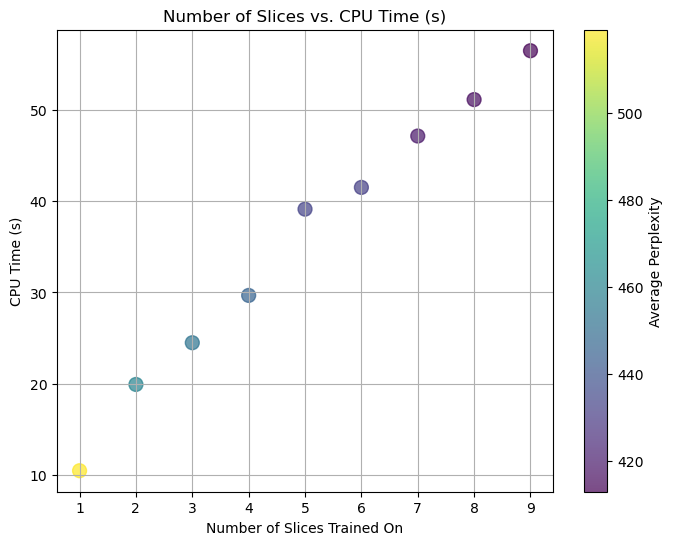

In [150]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Number of slices trained on'], df['CPU Time (s)'], c=df['Average perplexity'], cmap='viridis', s=100, alpha=0.7)
plt.title('Number of Slices vs. CPU Time (s)')
plt.xlabel('Number of Slices Trained On')
plt.ylabel('CPU Time (s)')
plt.colorbar(label='Average Perplexity')
plt.grid(True)
plt.show()

## Analysis 

The data analysis reveals that as the number of slices trained on increases, there is a general upward trend in average perplexity, CPU time, and disk space usage. This suggests a trade-off between improving model understanding (lower perplexity) and resource requirements. While training on more data may enhance the model's performance, it demands increased computational resources and storage space.

# c. Best Model

In [151]:
start_time = time.time()
Bimodel = kenlm.LanguageModel(r"C:\Users\barka\Desktop\NLP\Model\Bimodel.arpa")
end_time = time.time()
loading_time = end_time - start_time
print(f"Model loading time: {loading_time:.4f} seconds")

Model loading time: 8.1727 seconds


In [152]:
start_time = time.time()
Trimodel = kenlm.LanguageModel(r"C:\Users\barka\Desktop\NLP\Model\Trimodel.arpa")
end_time = time.time()
loading_time = end_time - start_time
print(f"Model loading time: {loading_time:.4f} seconds")

Model loading time: 41.3070 seconds


In [153]:
start_time = time.time()
Quadmodel = kenlm.LanguageModel(r"C:\Users\barka\Desktop\NLP\Model\Quadmodel.arpa")
end_time = time.time()
loading_time = end_time - start_time
print(f"Model loading time: {loading_time:.4f} seconds")

Model loading time: 111.2460 seconds


In [154]:
start_time = time.time()
Pentamodel = kenlm.LanguageModel(r"C:\Users\barka\Desktop\NLP\Model\Pentamodel.arpa")
end_time = time.time()
loading_time = end_time - start_time
print(f"Model loading time: {loading_time:.4f} seconds")

Model loading time: 180.2113 seconds


In [155]:
perplexities_by_best_model = []
perplexities = []
for sentence in sentences:
    sentence_filtered = sentence.replace('\n', '')
    score = Bimodel.perplexity(sentence_filtered)
    perplexities.append(score)
    
perplexities_by_best_model.append(perplexities)

In [156]:
perplexities = []
for sentence in sentences:
    sentence_filtered = sentence.replace('\n', '')
    score = Trimodel.perplexity(sentence_filtered)
    perplexities.append(score)
    
perplexities_by_best_model.append(perplexities)

In [157]:
perplexities = []
for sentence in sentences:
    sentence_filtered = sentence.replace('\n', '')
    score = Quadmodel.perplexity(sentence_filtered)
    perplexities.append(score)
    
perplexities_by_best_model.append(perplexities)

In [158]:
perplexities = []
for sentence in sentences:
    sentence_filtered = sentence.replace('\n', '')
    score = Pentamodel.perplexity(sentence_filtered)
    perplexities.append(score)
    
perplexities_by_best_model.append(perplexities)

In [159]:
perplexities_by_model = np.array(perplexities_by_best_model)
avg_perplexities_by_best_model = np.mean(perplexities_by_best_model, axis = 1)
avg_perplexities_by_best_model

array([412.93303849, 317.5932022 , 303.8630148 , 301.97724712])

In [160]:
Temps_CPU = np.array([56.4883, 154.045, 485.135, 843.09])
Memoire = np.array([244980, 1217636, 3235823, 5970728])
N_gramme = np.array([2, 3, 4, 5])
time_of_loading = np.array([8.3803, 41.4838, 110.1083, 189.1594])
column_values = ['N-gramme', 'Average perplexity', 'CPU Time (s)', 'Disk space (kB)', 'Loading Time (s)']
index_values = ['Bimodel', 'Trimodel', 'Quadmodel', 'Pentamodel']

In [161]:
data = {'N-gramme': N_gramme,
        'Average perplexity': avg_perplexities_by_best_model,
        'CPU Time (s)': Temps_CPU,
        'Disk space (kB)' : Memoire,
        'Loading Time (s)': time_of_loading}

df = pd.DataFrame(data, columns=column_values, index=index_values)
df

N-gramme  Average perplexity  CPU Time (s)  Disk space (kB)  \
Bimodel            2          412.933038       56.4883           244980   
Trimodel           3          317.593202      154.0450          1217636   
Quadmodel          4          303.863015      485.1350          3235823   
Pentamodel         5          301.977247      843.0900          5970728   

            Loading Time (s)  
Bimodel               8.3803  
Trimodel             41.4838  
Quadmodel           110.1083  
Pentamodel          189.1594

## Opting for Efficiency: Choosing the Trimodel


In the context of selecting the optimal model among the choices, the Trimodel stands out as the preferred choice. While it may not have the absolute lowest perplexity score compared to the Pentamodel, it strikes a commendable balance between model performance and resource efficiency. The Trimodel offers a favorable compromise, boasting a substantially lower perplexity (317.59) than the Bimodel while being considerably more efficient in terms of both CPU time (154.05 seconds) and disk space usage (1,217,636 kB). Additionally, the Trimodel exhibits a relatively quick loading time (41.48 seconds), further contributing to its practicality for deployment and real-time usage. In summary, the Trimodel's impressive performance, coupled with its efficient resource utilization and swift loading times, positions it as the pragmatic choice for achieving a robust and practical language model solution.

# d. Small Questions

### i - Lines

In [40]:
# Concatenate all files
all_slices = pd.Series()

for i, slice_path in enumerate(glob.glob(PATH+"\*.txt")):
    slice_df = pd.read_table(slice_path, header=None)
    slice_df = slice_df[0].str.split("\n", expand=True)
    slice_np = slice_df.values.flatten()
    slice_series = pd.Series(slice_np).dropna()
    
    all_slices = pd.concat([all_slices, slice_series])
all_slices = all_slices.reset_index(drop=True)

all_slices

C:\Users\Louis\AppData\Local\Temp\ipykernel_33784\2417323933.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_slices = pd.Series()


0          The U.S. Centers for Disease Control and Preve...
1          When Ms. Winfrey invited Suzanne Somers to sha...
2          Elk calling -- a skill that hunters perfected ...
3                                                   Don 't !
4          Fish , ranked 98th in the world , fired 22 ace...
                                 ...                        
2756008    ( AP ) The Supreme Court says Shell Oil Co. ca...
2756009    Rangel is the subject of another larger ethics...
2756010    Mr Spitzer is reported to have paid thousands ...
2756011     No one can pretend it is a highly tactical fo...
2756012    Where Ubisoft and developer Gameloft really do...
Length: 2756013, dtype: object

### ii - Repeats

In [41]:
# Count repeats
sentence_counts = all_slices.value_counts()
seen_3 = sentence_counts[sentence_counts>=3]
seen_4 = sentence_counts[sentence_counts>=4]

In [42]:
seen_3

American negotiator Watson said the Bush administration is planning probably four more meetings in the Major Economies series before a " leaders ' meeting " in mid-2008 presents a final outcome .    3
dtype: int64

In [43]:
seen_4

Series([], dtype: int64)

### iii - Characters

In [44]:
sentence_lengths = all_slices.str.len()
sentence_lengths_counts = sentence_lengths.value_counts()
length_20 = sentence_lengths_counts.loc[20]
length_120 = sentence_lengths_counts.loc[120]

print(f"Number of occurences per caracter lengths: \n20: {length_20}\n120: {length_120}")

Number of occurences per caracter lengths: 
20: 3182
120: 16100


### iv - Max & min

In [45]:
print(f"Shortest sentence length: {sentence_lengths.min()}\nLongest sentence length: {sentence_lengths.max()}")

Shortest sentence length: 2
Longest sentence length: 9572


### v - Short sentence frequency

In [46]:
less_21 = all_slices[sentence_lengths < 21]
less_21_counts = less_21.value_counts()
less_21_counts.head(100).to_csv(PATH+"\\frequent_short_sentences.csv")

### vi - Word frequency

In [37]:
# Concatenate everything into a single string
all_slices_str = ""

pattern = r'[^\w\s]|[\d]' # Regex to select punctuation and digits
for slice_path in glob.glob(PATH+"\*.txt"):
    f = open(slice_path, "r", encoding="utf-8")
    slice_str = f.read()

    # Replacing punctuation, digits and skip lines
    slice_str = re.sub("\n", ' ', slice_str) # Skipline becomes space
    slice_str = re.sub(pattern, '', slice_str).lower()  # Remove punctuation and digits, then put it in lowercase
    
    # Concatenating
    all_slices_str = all_slices_str + slice_str
words = all_slices_str.split("continue to ")
word_df = pd.Series(words)
word_df = word_df.drop(0) # Because there is no "continue to" to split over on the first line
word_df = word_df.str.split(" ", expand=True)

next_word = word_df[0]
next_word_counts = next_word.value_counts()

six_next_words = word_df.iloc[:, 0:6]
six_next_words = six_next_words[0] + " " + six_next_words[1] + " " + six_next_words[2] + " " + six_next_words[3] + " " + six_next_words[4] + " " + six_next_words[5]


In [38]:
next_word_counts.head(6)

be      621
work    209
do      165
grow    139
rise    126
have    114
Name: 0, dtype: int64

In [39]:
six_next_words.value_counts()

serve as chairman of the board                       3
act to strengthen and stabilize our                  3
complement fiscal stimulus with strong government    3
show restraint in dealing with those                 3
drive innovation to capture market opportunities     2
                                                    ..
do so but did not give                               1
hope  availability has improved                      1
prohibit significant development in the iraqi        1
work on aiding poorer countries after                1
reflect a disciplined approach to review             1
Length: 6478, dtype: int64

### vii - First 10  words

In [47]:
sentence_starts = []

for slice_path in glob.glob(PATH+"\*.txt"):
    f = open(slice_path, "r", encoding="utf-8")
    slice_str = f.readlines()

    for sentence in slice_str:
        sentence = sentence.split(" ")
        first_10 = sentence[:10]
        
        first_10_str = ""
        for word in first_10:
            first_10_str = first_10_str + " " + word
        sentence_starts.append(first_10_str)

sentence_starts = pd.Series(sentence_starts)
sentence_starts.value_counts()

 A version of this article appeared in print on March                   113
 The yield on the benchmark 10-year Treasury note , which               109
 A version of this article appeared in print on January                  77
 Enterprise computing , economics of technology , Microsoft , I.B.M.     69
 This entry was posted by Gwen Robinson on Wednesday ,                   64
                                                                       ... 
 Even though his land is only six miles from official                     1
 The policy was designed to control the country 's exploding              1
 Rogge urged China to respect its " moral engagement "                    1
 They also include zebra and quagga mussels , which have                  1
 Where Ubisoft and developer Gameloft really do pull through is           1
Length: 2738435, dtype: int64

### viii - Maj

In [4]:
# Concatenate everything into a single string
all_slices_str = ""

pattern = r'[^\w\s]|[\d]' # Regex to select punctuation and digits
for slice_path in glob.glob(PATH+"\*.txt"):
    f = open(slice_path, "r", encoding="utf-8")
    slice_str = f.read()

    # Replacing punctuation, digits and skip lines
    slice_str = re.sub("\n", ' ', slice_str) # Skipline becomes space
    slice_str = re.sub(pattern, '', slice_str)  # Remove punctuation and digits
        
    # Concatenating
    all_slices_str = all_slices_str + slice_str

# Split over the spaces, removing them and putting them into pandas
words = all_slices_str.split(" ")
word_df = pd.Series(words)

word_df_upper = word_df[word_df.str.isupper()]
word_df_upper_4 = word_df_upper[word_df_upper.str.len()==4]
word_df_upper_4_counts = word_df_upper_4.value_counts()
word_df_upper_4_counts.to_csv(PATH + r"\most_common_4maj_words.csv")
word_df_upper_4_counts.head(5)

YORK    5512
NATO    3133
NASA    2238
NYSE    1720
AIDS    1437
dtype: int64